In [61]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Read the crime data
"""
Crime Data has the following columns:
    ['activityNumber', 'activityType', 'activityDate', 'Year',
       'violationSection', 'violationType', 'chargeDescription', 'codeUcr',
       'BlockNumber', 'streetDirection', 'streetName', 'streetType', 'city',
       'state', 'zipCode', 'beat']
"""
crime_data = pd.read_excel('PRA 21-4922_2019-2021_Crimes__UCR Revised.xlsx')

# read the stop data
"""
Stop Data has the following columns:
    ['Unnamed: 0', 'stop_id', 'pid', 'id', 'ori', 'agency', 'exp_years',
       'date', 'time', 'dur', 'is_serv', 'assign_key', 'assign_words',
       'inters', 'block', 'ldmk', 'street', 'hw_exit', 'is_school',
       'school_name', 'city', 'beat', 'beat_name', 'is_student', 'lim_eng',
       'age', 'gender_words', 'is_gendnc', 'gender_code', 'gendnc_code',
       'lgbt', 'race', 'disability', 'reason_words', 'reasonid', 'reason_text',
       'reason_detail', 'reason_exp', 'search_basis', 'search_basis_exp',
       'seiz_basis', 'prop_type', 'cont', 'actions', 'act_consent']
"""
stops_2019 = pd.read_csv('master-ripa-2019.csv')
stops_2020 = pd.read_csv('master-ripa-2020.csv')
stops_2021 = pd.read_csv('master-ripa-2021.csv')

# read the beat demographics data
"""
Beat Demographics Data has the following columns:
    ['beat', 'total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp']
"""
beat_demographics = pd.read_csv('beat_demographics_2019_acs.csv')

c:\Users\Ahmad\anaconda3\envs\green\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (15,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Combine stops data from 2019, 2020, and 2021
stops_data = pd.concat([stops_2019, stops_2020, stops_2021])

Fix Race Labels in the stop data

In [27]:
# print number of unique race values
print(len(stops_data["race"].unique()))

146


In [33]:
# convert race to string typ
stops_data["race"] = stops_data["race"].astype(str)

In [39]:
len(stops_data["race"].unique())

146

In [35]:
# print first 5 instances of race
stops_data["race"].head()

0          Hispanic/Latino/a
1                      White
2    Hispanic/Latino/a|White
3          Hispanic/Latino/a
4     Black/African American
Name: race, dtype: object

In [37]:
# check if the first 5 have "|" in them
stops_data["race"][0:5].str.contains('\\|', regex=True).sum()

1

In [38]:
multiracial_count = stops_data['race'].str.contains('\\|', regex=True).sum()
total_count = len(stops_data)
print(f"Multiracial count: {multiracial_count} out of {total_count} ({100 * multiracial_count / total_count:.2f}%)")

Multiracial count: 3767 out of 407684 (0.92%)


In [40]:
# count the unique values in the race column that do not contain '\\|'
stops_data["race"][~stops_data["race"].str.contains('\\|', regex=True)].value_counts()

White                            168446
Hispanic/Latino/a                119515
Black/African American            81387
Asian                             19647
Middle Eastern or South Asian     11001
Pacific Islander                   3112
Native American                     809
Name: race, dtype: int64

In [42]:
def simplify_race(race):
    if 'White' in race:
        return 'white'
    elif 'Black/African American' in race:
        return 'black'
    elif 'Asian' in race:
        return 'asian'
    elif 'Hispanic/Latino/a' in race:
        return 'hisp'
    elif 'Native American' in race:
        return 'aian'
    elif 'Pacific Islander' in race:
        return 'nhopi'
    elif 'Middle Eastern or South Asian' in race:
        return 'other'
    else:
        return 'other'

In [43]:
# apply the simplify_race function to the race column
stops_data["race"] = stops_data["race"].apply(simplify_race)

Add other race to demographic data

In [44]:
beat_demographics['other'] = beat_demographics['total'] - (
    beat_demographics['white'] + 
    beat_demographics['black'] + 
    beat_demographics['aian'] + 
    beat_demographics['asian'] + 
    beat_demographics['nhopi'] + 
    beat_demographics['hisp']
)


In [46]:
# Group crime and stops data by beat
crime_by_beat = crime_data.groupby('beat').size().reset_index(name='num_crimes')
stops_by_beat = stops_data.groupby(['beat', 'race']).size().reset_index(name='num_stops')

# Merge crime and stops data by beat
crime_stops_by_beat = pd.merge(crime_by_beat, stops_by_beat, on='beat')

# Merge crime_stops_by_beat with beat_demographics
crime_stops_demographics_by_beat = pd.merge(crime_stops_by_beat, beat_demographics, on='beat')

# Calculate the ratio of stops to crimes in each beat
crime_stops_demographics_by_beat['stops_to_crimes_ratio'] = crime_stops_demographics_by_beat['num_stops'] / crime_stops_demographics_by_beat['num_crimes']

# Calculate the proportion of stops for each racial group in each beat
racial_groups = ['white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']
for group in racial_groups:
    crime_stops_demographics_by_beat[f'{group}_stops_proportion'] = crime_stops_demographics_by_beat.loc[crime_stops_demographics_by_beat['race'] == group, 'num_stops'] / crime_stops_demographics_by_beat[group]

In [47]:
# Display the results
print(crime_stops_demographics_by_beat.sort_values(by='stops_to_crimes_ratio', ascending=False))

      beat  num_crimes   race  num_stops  total  white  black  aian  asian  \
155  316.0          36  white        245   1163    691     57     3    102   
516  714.0         231   hisp       1098    194      4      5     0      6   
500  711.0          33   hisp        125   8205    482    243     0    397   
432  614.0        2277  white       7985  10937   8657    260    14    314   
92   235.0          32  white        100   2654   1591     35     0    324   
..     ...         ...    ...        ...    ...    ...    ...   ...    ...   
70   232.0         845   aian          1  11531   5652    204     8   4089   
53   124.0        3401   aian          4  30257  22649    552     8   2980   
104  243.0         931   aian          1   6173   2021    275    45   2134   
543  725.0        1077   aian          1   4999    881    541    16    954   
23   115.0        4017   aian          2  49954  24314    871   220  16481   

     nhopi  hisp  other  stops_to_crimes_ratio  white_stops_pro

In [50]:
# print the data for beat 316
crime_stops_demographics_by_beat[crime_stops_demographics_by_beat['beat'] == 935]

,beat,num_crimes,race,num_stops,total,white,black,aian,asian,nhopi,hisp,other,stops_to_crimes_ratio,white_stops_proportion,black_stops_proportion,aian_stops_proportion,asian_stops_proportion,nhopi_stops_proportion,hisp_stops_proportion,other_stops_proportion
706,935.0,251,asian,81,9513,5535,25,6,2731,16,706,494,0.322709,NaN,NaN,NaN,0.029659,NaN,NaN,NaN
707,935.0,251,black,42,9513,5535,25,6,2731,16,706,494,0.167331,NaN,1.68,NaN,NaN,NaN,NaN,NaN
708,935.0,251,hisp,132,9513,5535,25,6,2731,16,706,494,0.525896,NaN,NaN,NaN,NaN,NaN,0.186969,NaN
709,935.0,251,nhopi,4,9513,5535,25,6,2731,16,706,494,0.015936,NaN,NaN,NaN,NaN,0.25,NaN,NaN
710,935.0,251,white,432,9513,5535,25,6,2731,16,706,494,1.721116,0.078049,NaN,NaN,NaN,NaN,NaN,NaN


## Visualize the data

In [53]:
# Read the shapefile
shapefile_path = 'pd_beats_datasd/pd_beats_datasd.shp'
beat_geodata = gpd.read_file(shapefile_path)

In [54]:
# Convert beat column to numeric
beat_geodata['beat'] = pd.to_numeric(beat_geodata['beat'])

In [55]:
# Aggregate the stop data by beat (replace 'count' with the column of interest)
aggregated_stops = stops_data.groupby(['beat']).size().reset_index(name='count')

# Merge the geodata with the aggregated stop data
merged_geodata = beat_geodata.merge(aggregated_stops, on='beat')

c:\Users\Ahmad\anaconda3\envs\green\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


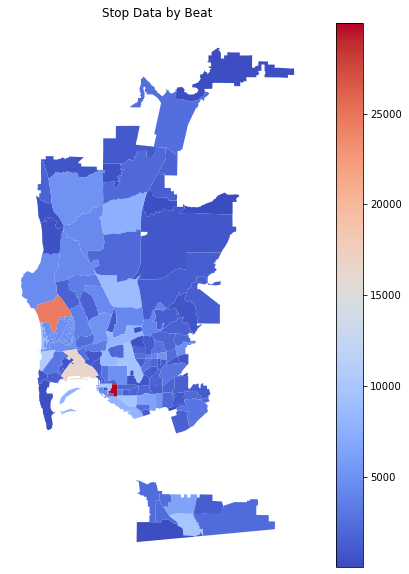

In [56]:
# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_geodata.plot(column='count', cmap='coolwarm', legend=True, ax=ax)
ax.set_title('Stop Data by Beat')
ax.set_axis_off()
plt.show()